In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import Constraint, SolverFactory, value, Param, Expression, Var
from pyomo.network import Arc

from HDA_Flowsheet import HDA_Flowsheet
from Method import (print_outcome, 
                   stream_report, 
                   stream_information, 
                   vessel_info,
                   heater_info,
                   cost_vessel, 
                   cost_fired_heater)

2024-04-30 14:22:18.031531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
m = HDA_Flowsheet()

Building flowsheet...

[2024-04-30 14:22:19] Inlet_Feed Block is created successfully!
[2024-04-30 14:22:19] R101 Block is created successfully!
[2024-04-30 14:22:19] H101 Block is created successfully!
[2024-04-30 14:22:19] F101 Block is created successfully!
[2024-04-30 14:22:19] F102 Block is created successfully!
[2024-04-30 14:22:19] M101 Block is created successfully!
[2024-04-30 14:22:19] S101 Block is created successfully!
[2024-04-30 14:22:19] Outlet_Flow Block is created successfully!

Units list: ['Inlet_Feed', 'R101', 'H101', 'F101', 'F102', 'M101', 'S101', 'Outlet_Flow']
Setting inputs...

Initializing flowsheet...

Limiting Wegstein tear to 5 iterations to obtain initial solution, if not converged IPOPT will pick up and continue.



2024-04-30 14:22:19.865756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


model.name="F101";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
Solving flowsheet...

Ipopt 3.13.2: tol=0.001


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity

In [5]:
item = [Constraint, Expression]
scale_stat = []
for i in item:
    scale_stat.append(sum(1 for i in m.component_data_objects(i)))

dic=dict(zip(item,scale_stat))
dic

{pyomo.core.base.constraint.Constraint: 708,
 pyomo.core.base.expression.Expression: 137}

In [7]:
# define the economical metrics as Objective
unit_list = [m.H101, m.R101, m.F101, m.F102]
m.period = Param(default = 15)
m.int_rate = Param(default = 0.065)
m.instal_factor = Param(default = 5.8)

@m.Expression()
def annual_factor(m):
    return m.int_rate*(1+m.int_rate)**m.period/((1.+m.int_rate)**m.period-1.)

@m.Expression()
def equipment_cost(m):
    return sum(unit.capital_cost for unit in unit_list)

@m.Expression()
def annual_total_capital_cost(m):
    return m.equipment_cost*m.annual_factor*m.instal_factor

@m.Expression()
def Total_annual_cost(m):
    return m.operating_cost + m.annual_total_capital_cost

@m.Expression()
def production(m): # t/year
    return m.F102.Vap_Outlet.flow["Vap", "benzene"] * 8000 * 3600 * 78 / 1e3

@m.Objective()
def Unit_cost(m):
    return m.Total_annual_cost/m.production

In [8]:
econ_compare={'purity': [],
              'loss': [],
              'product': [],
              'Cost': []
             }
eco_index = [m.purity, m.loss, m.product, m.Unit_cost]
for i,key in enumerate(econ_compare):
    econ_compare[key].append(value(eco_index[i]))

In [9]:
# set some decision variables
m.H101.Outlet.T.unfix()
m.R101.Q.unfix()
m.F101.Vap_Outlet.T.unfix()
m.F102.Vap_Outlet.T.unfix()
m.F102.Vap_Outlet.P.unfix()
#m.S101.recycle_ratio.unfix()

# 加热器温度
m.H101.Outlet.T.setlb(500)
m.H101.Outlet.T.setub(800)

# 反应器温度
m.R101.Outlet.T.setlb(550)
m.R101.Outlet.T.setub(900)

# F101出口温度，F102出口温度和压力
m.F101.Vap_Outlet.T.setlb(300.0)
m.F101.Vap_Outlet.T.setub(350.0)
m.F102.Vap_Outlet.T.setlb(350.0)
m.F102.Vap_Outlet.T.setub(400.0)
m.F102.Vap_Outlet.P.setlb(140000)
m.F102.Vap_Outlet.P.setub(160000)

m.overhead_loss = Constraint(expr=m.loss<=0.08)
m.product_flow = Constraint(expr=m.product>= 64.1) # kmol/hr
m.product_purity = Constraint(expr=m.purity >= 0.8)

In [10]:
solver = SolverFactory('ipopt')
solver.options['tol'] = 1e-6
solver.options['max_iter'] = 5000
results = solver.solve(m, tee=True)

Ipopt 3.13.2: tol=1e-06
max_iter=5000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        

In [11]:
for i,key in enumerate(econ_compare):
    econ_compare[key].append(value(eco_index[i]))

In [12]:
Compare = pd.DataFrame(econ_compare).transpose()
Compare.columns = ['Heuristic','Optimized']
Compare=Compare.transpose()
Compare['purity']=Compare['purity']*100
Compare['loss']=Compare['loss']*100
Compare['product']=Compare['product']*78.1136/1e3 # kg/hr

In [13]:
Compare

,purity,loss,product,Cost
Heuristic,85.379835,11.445217,3.668874,76.095597
Optimized,82.602774,5.639119,5.347702,41.092810


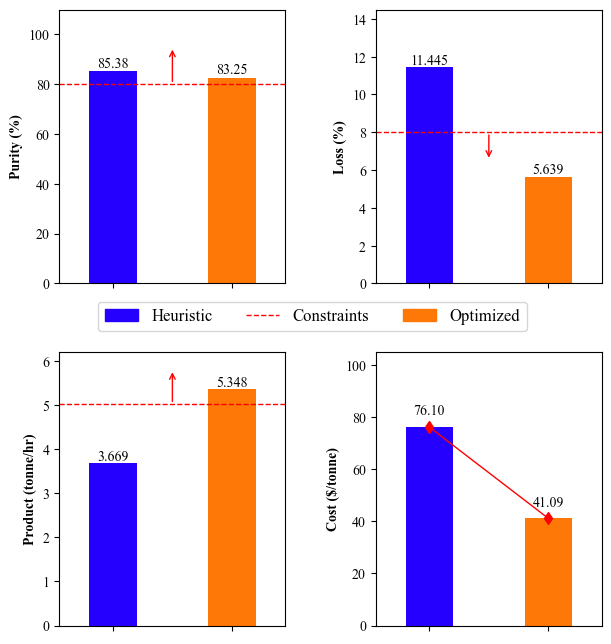

In [14]:
blue = [37/255,0/255,254/255]
yellow = [253/255,120/255,6/255]
plt.rcParams['font.family']='Times New Roman'

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

fig, ax = plt.subplots(2,2,figsize=(7,8))
Compare['purity'].plot(ax=ax[0, 0], x=[0,1],width=0.4, kind='bar', color=[blue,yellow], legend=False)
ax[0][0].tick_params(axis='x', bottom=True, top=False, labeltop=False, labelbottom=False)
ax[0][0].set_ylim([0,110])
ax[0][0].set_ylabel('Purity (%)',weight='bold')
ax[0][0].axhline(y=80, color='r', linestyle='--',linewidth=1)
ax[0][0].text(0, 85.38,'85.38',ha='center', va='bottom')
ax[0][0].text(1, 83.25,'83.25',ha='center', va='bottom')
ax[0][0].annotate('', xy=(0.5, 95), xytext=(0.5, 80),
             arrowprops=dict(color='red', arrowstyle='->'),
             fontsize=10, fontname='Times New Roman')


Compare['loss'].plot(ax=ax[0, 1], x=[0,1],width=0.4,kind='bar', color=[blue,yellow], legend=False)
ax[0][1].tick_params(axis='x', bottom=True, top=False, labeltop=False, labelbottom=False)
ax[0][1].set_ylim([0,14.5])
ax[0][1].set_ylabel('Loss (%)',weight='bold')
ax[0][1].axhline(y=8, color='r', linestyle='--',linewidth=1)
ax[0][1].text(0, 11.445,'11.445',ha='center', va='bottom')
ax[0][1].text(1, 5.639,'5.639',ha='center', va='bottom')
ax[0][1].annotate('', xy=(0.5, 6.5), xytext=(0.5, 8),
             arrowprops=dict(color='red', arrowstyle='->'),
             fontsize=10, fontname='Times New Roman')

Compare['product'].plot(ax=ax[1, 0], width=0.4,kind='bar', color=[blue,yellow], legend=False)
ax[1][0].tick_params(axis='x', bottom=True, top=False, labeltop=False, labelbottom=False)
ax[1][0].set_xticklabels(['Heuristic','Optimized'], rotation=0)
ax[1][0].set_ylabel('Product (tonne/hr)',weight='bold')
ax[1][0].axhline(y=64.1*78.1136/1e3, color='r', linestyle='--',linewidth=1)
ax[1][0].text(0, 3.669,'3.669',ha='center', va='bottom')
ax[1][0].text(1, 5.348,'5.348',ha='center', va='bottom')
ax[1][0].set_ylim([0,6.2])
ax[1][0].annotate('', xy=(0.5, 5.8), xytext=(0.5, 5.01),
             arrowprops=dict(color='red', arrowstyle='->'),
             fontsize=10, fontname='Times New Roman')

Compare['Cost'].plot(ax=ax[1, 1], width=0.4,kind='bar', color=[blue,yellow], legend=False)
ax[1][1].tick_params(axis='x', bottom=True, top=False, labeltop=False, labelbottom=False)
ax[1][1].plot(['Heuristic','Optimized'],[Compare.iloc[0,3],Compare.iloc[1,3]],color='r', linestyle='-', marker='d',linewidth=1)
ax[1][1].set_ylabel('Cost ($/tonne)',weight='bold')
ax[1][1].text(0, 76.10+3.5,'76.10',ha='center', va='bottom')
ax[1][1].text(1, 41.09+3.5,'41.09',ha='center', va='bottom')
ax[1][1].set_ylim([0,105])
ax[1][1].set_xticklabels(Compare.index,rotation=0)

# Create custom legend elements
blue_patch = mpatches.Patch(color=blue, label='Heuristic')
yellow_patch = mpatches.Patch(color=yellow, label='Optimized')
red_line = mlines.Line2D([], [], color='red', linestyle='--', label='Constraints',linewidth=1)

fig.subplots_adjust(hspace=0.25, wspace=0.4)
# Add the custom legend elements to the legend
fig.legend(handles=[blue_patch,red_line, yellow_patch],ncol=3,loc=(0.16,0.485),fontsize=12)

#fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Optimized comparation.png',dpi=450,bbox_inches='tight')

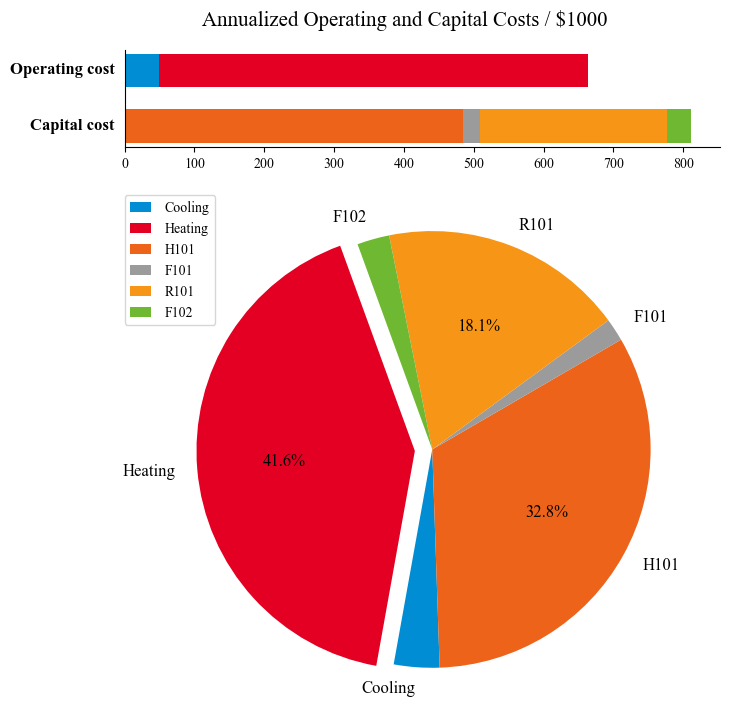

In [15]:
import matplotlib.pyplot as plt

c1 = [228/255, 0/255, 35/255]
c2 = [237/255, 99/255, 26/255]
c3 = [246/255, 149/255, 22/255]
c4 = [155/255, 155/255, 155/255]
c5 = [111/255, 185/255, 50/255]
c6 = [0/255, 141/255, 211/255]

def plot_econ(m):
    unit_list = [m.H101, m.F101, m.R101, m.F102]
    
    opecost = {
        "cooling": value(3600 * 8000 * m.cooling_cost / 1e3),
        "heating": value(3600 * 8000 * m.heating_cost / 1e3),
    }
    capcost = {unit.name: value(unit.capital_cost*m.annual_factor*m.instal_factor / 1e3) for unit in unit_list}
    
    y_axis = ['Capital cost','Operating cost']
    fig, ax = plt.subplots(2,1, figsize=(7, 8), gridspec_kw={'height_ratios': [1, 5]})
    
    bar_width = 0.6  
    bar_opacity = 1
    
    heating_color = c1
    cooling_color = c6
    capital_colors = [c2, c4, c3, c5]
    
    ax[0].barh(1, opecost['cooling'], label='Cooling', color=cooling_color, alpha=bar_opacity, height=bar_width)
    ax[0].barh(1, opecost['heating'], left=opecost['cooling'], label='Heating', color=heating_color, alpha=bar_opacity, height=bar_width)

    # Plotting each capital cost with a different color
    capcost_value = []
    for i in capcost.values():
        capcost_value.append(i)
    
    bottoms = [0] + [sum(capcost_value[:i+1]) for i in range(len(capcost_value)-1)]
    
    for i, (cost, color) in enumerate(zip(capcost_value, capital_colors)):
        ax[0].barh(0, cost, left=bottoms[i], label=unit_list[i], color=color, alpha=bar_opacity, height=bar_width)
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].set_yticks([0, 1])  # Setting the x-ticks at 0 and 1
    ax[0].set_yticklabels(y_axis, rotation=0,ha='right', va='center',weight='bold',fontsize=12)
    ax[0].tick_params(axis='y', which='both', bottom=False,left=False)
    ax[0].tick_params(axis='x', direction='out', bottom=True, top=False, labeltop=False, labelbottom=True)
    ax[0].xaxis.set_label_position('bottom')
    
    ax[0].legend(bbox_to_anchor=(0, -0.5), loc=2, borderaxespad=0.,handlelength=1.5, handletextpad=1)
    
    # Calculate total costs
    total_cost = sum([opecost['heating'], opecost['cooling']] + capcost_value)
    
    # Calculate percentages of each cost
    percentages = [(opecost['heating'] / total_cost) * 100,
                   (opecost['cooling'] / total_cost) * 100] + [(cost / total_cost) * 100 for cost in capcost_value]
    
    # Labels for the pie chart
    labels = ['Heating', 'Cooling', 'H101', 'F101', 'R101', 'F102']
    
    # Colors for each section of the pie chart
    pie_colors = [heating_color, cooling_color] + capital_colors
    
    # Explode the first two sections (Heating and Cooling)
    explode = (0.08, 0) + tuple([0] * (len(capcost_value)))
    
    # Plotting the pie chart
    ax[1].pie(percentages, labels=labels, explode=explode, colors=pie_colors,
              autopct=lambda p: '{:.1f}%'.format(p) if p > 10 else '', startangle=110,
              textprops={'fontsize': 12})
        
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax[1].axis('equal')

    fig.suptitle('Annualized Operating and Capital Costs / $1000',fontsize=15, y=0.95)
    plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)

    return fig, ax
plot_econ(m)
plt.show()

In [16]:
df = stream_information(m)
df

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11
温度/˚C,30.05,30.05,28.3,226.85,442.44,26.85,26.85,26.85,26.85,105.36,105.36
压力/kPa,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,140.0,140.0
相态,气相,液相,气液共存,气相,气相,气相,气相,气相,液相,气相,液相
摩尔流量kmol/hr,237.888,131.94,1350.501,1350.501,1350.501,1225.841,980.673,245.168,124.661,68.461,56.2
质量流率kg/hr,-,-,-,-,-,-,-,-,-,-,-
->苯,0.01,0.01,2300.16,2300.16,10197.26,2875.18,2300.14,575.04,7322.08,4492.87,2829.22
->甲苯,0.01,12157.02,12420.25,12420.25,3105.07,329.03,263.22,65.81,2776.04,935.24,1840.81
->甲烷,356.93,0.0,8229.07,8229.07,9850.98,9840.18,7872.15,1968.04,10.8,10.78,0.02
->氢气,434.73,0.0,1357.41,1357.41,1153.6,1153.35,922.68,230.67,0.25,0.24,0.0
质量分率,-,-,-,-,-,-,-,-,-,-,-


In [18]:
print_outcome(m)

Decision Variables: 
     H101 outlet temperature = 500.00K
     R101 outlet temperature = 715.59K
     F101 outlet temperature = 300.00K
     F102 outlet temperature = 378.51K
     F102 outlet pressure = 140.00kPa
With total inlet feed 369.83 kmol/hr, 
Cost $41.09 per tonne benzene produced.

Outcome: 
	 Total Annual Cost = $1474849.04
	 Benzene Purity  = 0.83
	 Benzene Product = 68.46
	 Overhead Loss   = 0.06



In [19]:
vessel_information = pd.concat([vessel_info(m.R101),vessel_info(m.F101),vessel_info(m.F102)],axis=1)
vessel_information

,R101,F101,F102
Installation,horizontal,vertical,vertical
Material Type,Stainless Steel 304,CarbonSteel,CarbonSteel
Diameter,9.53 ft,2.57 ft,3.49 ft
Length,57.00 ft,7.71 ft,10.46 ft
Volume,4065.84 ft3,40.00 ft3,100.00 ft3
Shell Thickness,1.25 inch,1.25 inch,1.25 inch
Capital Cost,$432771.20,$40304.78,$57084.06


In [20]:
heater_info(m.H101)

,H101
Heat Source,Fuel
Material Type,Stainless Steel
Heat Duty,4861.30 kW
Pressure,350.00 kPa
Capital Cost,$785220.38
